[Moonbirds](https://moonbirds.xyz/) is the official PFP NFT project by the [Proof collective](https://collective.proof.xyz/). It consists of 10,000 utility-enabled PFPs that unlock different benefits depending on the traits and the locking period of the Moonbird NFT. 

The project went live on April 16th, 2022. 2,000 Moobirds were reserved for the Proof Collective Pass holders, [125 were reserved for the Moonbirds company wallet](https://twitter.com/moonbirds_xyz/status/1516937783704580097), and the remaining 7,875 were sold at 2.5 ETH to the winners of a raffle organized by Proof. Since its launch, the project has had immense success, breaking record after record,  and surpassing major NFT projects in total secondary sales volume and floor price. The project is ranked 9th in total secondary sales volume after one week of trading, and at the time of writing, the most expensive Moonbird sold for 1 Million USD, and the floor is above 100K USD.

In this blog post, we will use Python and Alchemy to do a deep dive analysis of the collection in its first week of trading. In section 1, we will cover how to download Moonbirds data using Python and Alchemy. In Section 2, we will do a deep dive analysis to understand better the sales trends, the price movements and the holders of Moonbirds.

The techniques from this tutorial can be used to analyze other NFT projects. You can find the source code and the data in this [github repository](https://github.com/adilmoujahid/moonbirds-data-analysis).

<div style="display:block;margin:auto;height:80%;width:80%">
  <img src="./images/moonbirds.png"/>
</div>

# 1. Moonbirds Data Collection and Structuring

There are various marketplaces for buying and selling Moonbirds and other NFTs. The most popular one is [opensea.io](https://opensea.io/). OpenSea also provides APIs that can be used to download NFT transactions and other types of data in a structured format. [In a previous post](http://adilmoujahid.com/posts/2021/06/data-mining-meebits-nfts-python-opensea/), I showed how to use python and opensea API to collect and analyze NFT data. Since then, Opensea made multiple modifications to the API and it requires now an API key to download the data. In addition, there have been new marketplaces like Looksrare that are growing in popularity and we want to take into account their transactions in our analysis. 

The good news is all NFT data is recorded in the blockchain and we can pull this data directly from the source. To do this, we will be using:
* [Alchemy](https://www.alchemy.com/): A blockchain developer platform that provides a suite of developer tools to interact with Ethereum and other blockchains.
* [A16Z NFT Analyst Starter Pack](https://github.com/a16z/nft-analyst-starter-pack): A set of Python scripts that make it easy to pull and structure NFT data.

For the tutorial, we will be using Python and I recommend [Anaconda](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-with-commands) to create a Python virtual environment for the analysis. I already collected and structured the data of the first week of trading. If you’re only interested in the analysis, skip to chapter 2. If you want to understand how to get and structure the data, check the next section.

## 1.1. Getting Data

Once you create and activate your Python virtual environment, from a terminal, clone the [A16Z NFT Analyst Starter Pack](https://github.com/a16z/nft-analyst-starter-pack) and install its dependencies by executing the following commands.

```
git clone git@github.com:a16z/nft-analyst-starter-pack.git
cd nft-analyst-starter-pack
pip3 install -r requirements.txt
```
Next, sign up for a free Alchemy account at [alchemy.com](alchemy.com) and get your Alchemy API key.

Next, we need to get the contract address of Moonbirds. We can get it by going to the official [Opensea page of Moonbirds](https://opensea.io/collection/proof-moonbirds) and clicking on the Etherscan logo. The contract address is  0x23581767a106ae21c074b2276d25e5c3e136a68b.

<br />
<br />

<div style="display:block;margin:auto;height:80%;width:80%">
     <img src="./images/moonbirds_opensea.png">
</div>

Next from a terminal, enter the A16Z NFT Analyst Starter Pack folder and execute the following command. Make sure to change "YourAPIKey" to your Alchemy API key.

```
python export_data.py --alchemy-api-key YourAPIKey --contract-address 0x23581767a106ae21c074b2276D25e5C3e136a68b
```

The command will take a couple of minutes to finish executing and outputting the data as three CSV files.
* sales_0x7Bd29408f11D2bFC23c34f18275bBf23bB716Bc7.csv
* transfers_0x7Bd29408f11D2bFC23c34f18275bBf23bB716Bc7.csv
* metadata_0x7Bd29408f11D2bFC23c34f18275bBf23bB716Bc7.csv

## 1.2. Augmenting and Structuring the Data

The sales and transfers CSV files contain the date of the transactions but not the time. Since we’re making the analysis using only one week's worth of data, it’s preferable to add the time of the transactions to have a more granular view of the data. To do this, we will using the web3 python library with the Alchemy API to get the timestamps of the transactions.

In [1]:
from datetime import datetime, date, timedelta 
from web3 import Web3
import pandas as pd

In [2]:
sales = pd.read_csv('./data/sales_0x23581767a106ae21c074b2276D25e5C3e136a68b.csv')
transfers = pd.read_csv('./data/transfers_0x23581767a106ae21c074b2276D25e5C3e136a68b.csv')

In [6]:
ALCHEMY_KEY = "YOUR_ALCHEMY_API_KEY"
w3 = Web3(Web3.HTTPProvider("https://eth-mainnet.alchemyapi.io/v2/"+ALCHEMY_KEY))

In [7]:
def get_timestamp(block_id):
    return w3.eth.getBlock(block_id)['timestamp']

sales['timestamp'] = sales['block_number'].apply(lambda x: get_timestamp(x))

Also, we don’t have an easy way to check who’s the owner of a Moonbird at a specific date. To solve this, we’ll create a DataFrame that has Moonbird asset_ids as index, the dates as  columns, and the addresses of the owners at the end of each trading day as values. 

In [9]:
def get_owners_daily(transfers):
    
    transfers['date'] = pd.to_datetime(transfers['date'])
    
    owners_dict = {}
    
    #Get first and last dates in transfers DF
    first_date = transfers['date'].min()
    last_date = transfers['date'].max()
    
    #Getting owners at the end of the first date
    this_data = transfers[transfers['date'] == first_date]
    asset_ids = pd.Series(name='asset_id', data=range(10000))
    this_data = this_data.merge(asset_ids, how='right', on='asset_id')
    owners = list(this_data.drop_duplicates(['asset_id'], keep='first')['to_address'])
    #print(owners)
    owners_dict[first_date] = owners.copy()
    
    this_date = first_date + timedelta(days=1)
    transfered_asset_ids = this_data['asset_id'].unique()
    while(this_date <= last_date):
        this_data = transfers[transfers['date'] == this_date]
        transfered_asset_ids = this_data['asset_id'].unique()
        for transfered_asset_id in transfered_asset_ids:
            owners[transfered_asset_id] = this_data[this_data['asset_id'] == transfered_asset_id].iloc[0]['to_address']
        owners_dict[this_date] = owners.copy()
        
        this_date += timedelta(days=1)
        
    return pd.DataFrame(owners_dict)

In [10]:
owners_daily = get_owners_daily(transfers)

Finally, we save the data into CSV files.

In [12]:
sales.to_csv('./data/sales.csv', index=False)
transfers.to_csv('./data/transfers.csv', index=False)
owners_daily.to_csv('./data/owners_daily.csv', index=False)

I also prepared 2 CSV files that contain the holders of the following NFT projects on the date of minting (April 16th) and on the date of writing this blog post (April 23rd). 
* Proof Collective
* Bored Ape Yacht Club (BAYC)
* Mutant Ape Yacht Club (MAYC)
* Bored Ape Kennel Club (BAKC)
* Meebits
* Doodles
* Cool Cats
* Azuki
* CLONE X
* World of Women

We will be using this data to check the intersection between Moonbirds owners and those NFT projects. I skipped Cryptopunks as it was challenging to get the owners list.

# 2. Analyzing the Data 

Now that we have the data in a structured format, we can work on our analysis. You can find the data we will be using [in this github repository](https://github.com/adilmoujahid/moonbirds-data-analysis). We start by reading importing the libraries that we need:

In [13]:
%matplotlib inline

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
from itertools import chain
from datetime import datetime, date, timedelta 
import pandas as pd

In [16]:
import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

In [17]:
plt.style.use('ggplot')

Next, we read the 3 data files that we need for the analysis.

In [49]:
## Reading the data
sales = pd.read_csv('./data/sales.csv')
metadata = pd.read_csv('./data/metadata.csv')
owners_daily = pd.read_csv('./data/owners_daily.csv')

In [50]:
#Parsing the dates
sales['date'] = pd.to_datetime(sales['date'])
sales['datetime'] = pd.to_datetime(sales['timestamp'], unit='s')

## 2.1. Sales and Prices Statistics

We start by analayzing Moonbirds' sales volume and prices. We will compute different statistics and plot a few graphs that shows the breakdown of the sales volume and the price evolution during the first week of trading.

In [51]:
start_date = sales['date'].min()
end_date = sales['date'].min()

start_date_str = str(start_date)[:10]
end_date_str = str(end_date)[:10]

In [46]:
def format_number(number, currency):
    
    suffixes = ['', 'K', 'M', 'B']
    
    if (number >= 10**9):
        return "{:,.0f}B {}".format(number/10**9, currency)
    elif (number >= 10**6):
        return "{:,.0f}M {}".format(number/10**6, currency)
    elif (number >= 10**3):
        return "{:,.0f}K {}".format(number/10**3, currency)
    else:
        return "{:,.2f} {}".format(number, currency)

### Total Volume, Highest and Average Sale Prices

In [47]:
max_sale_eth = sales['sale_price_eth'].max()
mean_sale_eth = sales['sale_price_eth'].mean()
total_sales_eth = sales['sale_price_eth'].sum()

max_sale_usd = sales['sale_price_usd'].max()
mean_sale_usd = sales['sale_price_usd'].mean()
total_sales_usd = sales['sale_price_usd'].sum()

print("The highest Moonbird sale between %s and %s is %s (%s)." 
      %(start_date_str, end_date_str, format_number(max_sale_eth, 'ETH'), format_number(max_sale_usd, 'USD')))

print("The average Moonbird sale between %s and %s is %s (%s)." 
      %(start_date_str, end_date_str, format_number(mean_sale_eth, 'ETH'), format_number(mean_sale_usd, 'USD')))

print("The total volume of Moonbird sales between %s and %s is %s (%s)." 
      %(start_date_str, end_date_str, format_number(total_sales_eth, 'ETH'), format_number(total_sales_usd, 'USD')))

The highest Moonbird sale between 2022-04-16 and 2022-04-23 is 350.00 ETH (1M USD).
The average Moonbird sale between 2022-04-16 and 2022-04-23 is 16.02 ETH (49K USD).
The total volume of Moonbird sales between 2022-04-16 and 2022-04-23 is 112K ETH (341M USD).


### Total Volume, Highest and Average Sale Prices broken down by Date

In [52]:
dates = list(sales['date'].unique())
dates_currencies = []
for date in dates:
    for currency in [' ', ' ']:
        dates_currencies.append( (date, currency) )
index = pd.MultiIndex.from_tuples(dates_currencies, names=[" ", " "])

total_daily_sales_eth = sales.groupby('date').sum()['sale_price_eth'].apply(lambda x: format_number(x, 'ETH'))
total_daily_sales_usd = sales.groupby('date').sum()['sale_price_usd'].apply(lambda x: format_number(x, 'USD'))
total_daily_sales = [x for y in zip(list(total_daily_sales_eth),list(total_daily_sales_usd)) for x in y]
mean_daily_sales_eth = sales.groupby('date').mean()['sale_price_eth'].apply(lambda x: format_number(x, 'ETH'))
mean_daily_sales_usd = sales.groupby('date').mean()['sale_price_usd'].apply(lambda x: format_number(x, 'USD'))
mean_daily_sales = [x for y in zip(list(mean_daily_sales_eth),list(mean_daily_sales_usd)) for x in y]
max_daily_sales_eth = sales.groupby('date').max()['sale_price_eth'].apply(lambda x: format_number(x, 'ETH'))
max_daily_sales_usd = sales.groupby('date').max()['sale_price_usd'].apply(lambda x: format_number(x, 'USD'))
max_daily_sales = [x for y in zip(list(max_daily_sales_eth),list(max_daily_sales_usd)) for x in y]

df = pd.DataFrame({'Total Volume': total_daily_sales, 'Average Sale': mean_daily_sales, 'Highest Sale': max_daily_sales}, index=index)
df

Total Volume Average Sale Highest Sale
                                                   
2022-04-23        37K ETH    10.08 ETH   110.00 ETH
                 112M USD      31K USD     335K USD
2022-04-22        24K ETH    15.77 ETH   135.00 ETH
                  73M USD      48K USD     414K USD
2022-04-21        11K ETH    22.12 ETH   118.00 ETH
                  34M USD      66K USD     353K USD
2022-04-20         6K ETH    20.20 ETH    83.00 ETH
                  19M USD      62K USD     254K USD
2022-04-19         8K ETH    24.89 ETH   150.00 ETH
                  25M USD      77K USD     466K USD
2022-04-18        13K ETH    36.08 ETH   175.00 ETH
                  39M USD     111K USD     539K USD
2022-04-17         6K ETH    36.80 ETH   205.00 ETH
                  18M USD     110K USD     612K USD
2022-04-16         7K ETH    42.47 ETH   350.00 ETH
                  20M USD     126K USD       1M USD

### Number of Moonbirds Sales per Day

Text(0, 0.5, 'Number of Moobirds Sales')

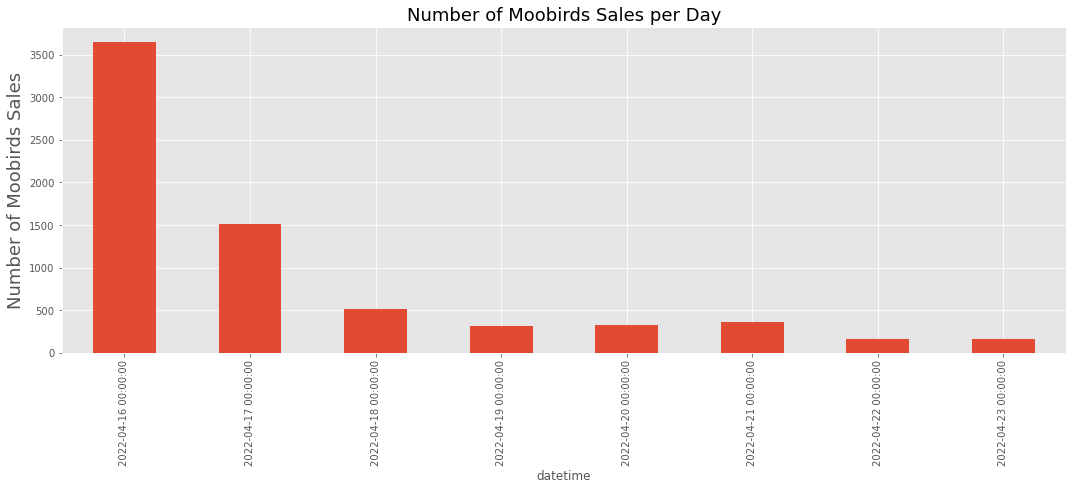

In [61]:
data = sales.resample('D', on='datetime').count()['sale_price_eth']
ax = data.plot.bar(figsize=(18, 6))

ax.set_alpha(0.8)
ax.set_title("Number of Moobirds Sales per Day", fontsize=18)
ax.set_ylabel("Number of Moobirds Sales", fontsize=18)

### Average Moonbird Price in ETH by day

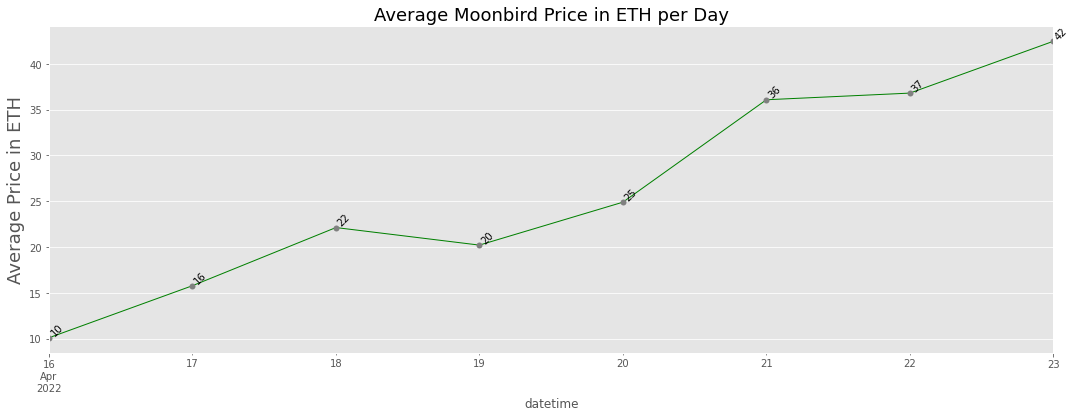

In [120]:
data = sales.resample('D', on='datetime').mean()['sale_price_eth']
ax = data.plot(figsize=(18,6), color="green", linewidth=1, marker='o', markerfacecolor='grey', markeredgewidth=0)

ax.set_alpha(0.8)
ax.set_title("Average Moonbird Price in ETH per Day", fontsize=18)
ax.set_ylabel("Average Price in ETH", fontsize=18);

dates = list(data.index)
values = list(data.values)

for i, j in zip(dates, values):
    ax.annotate(s="{:.0f}".format(j), xy=(i, j+.2), rotation=45)

### Zooming into the 2 first days of trading

Text(0, 0.5, 'Number of Moobirds Sales')

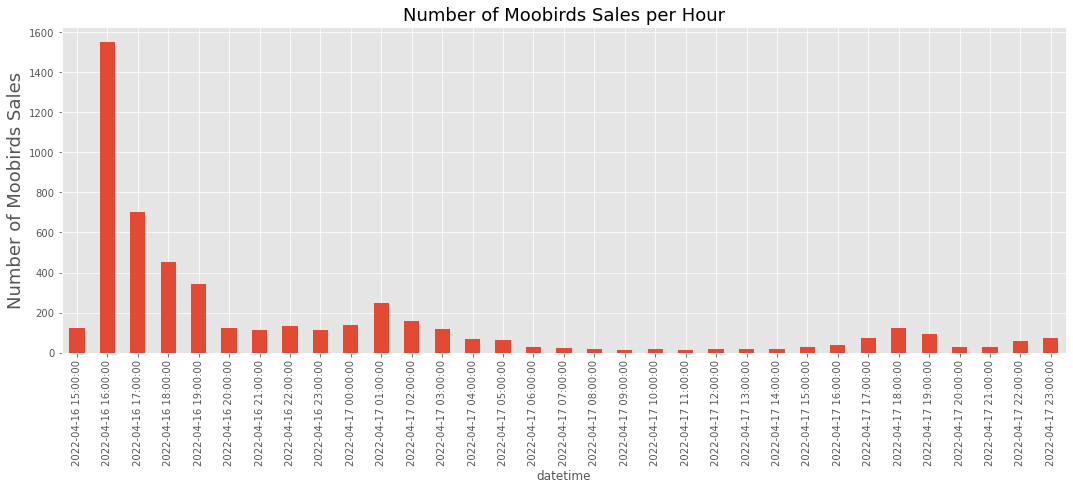

In [54]:
data = sales[sales['date'] < datetime(2022, 4, 18)]
data = data.resample('H', on='datetime').count()['sale_price_eth']
ax = data.plot.bar(figsize=(18, 6))

ax.set_alpha(0.8)
ax.set_title("Number of Moobirds Sales per Hour", fontsize=18)
ax.set_ylabel("Number of Moobirds Sales", fontsize=18)

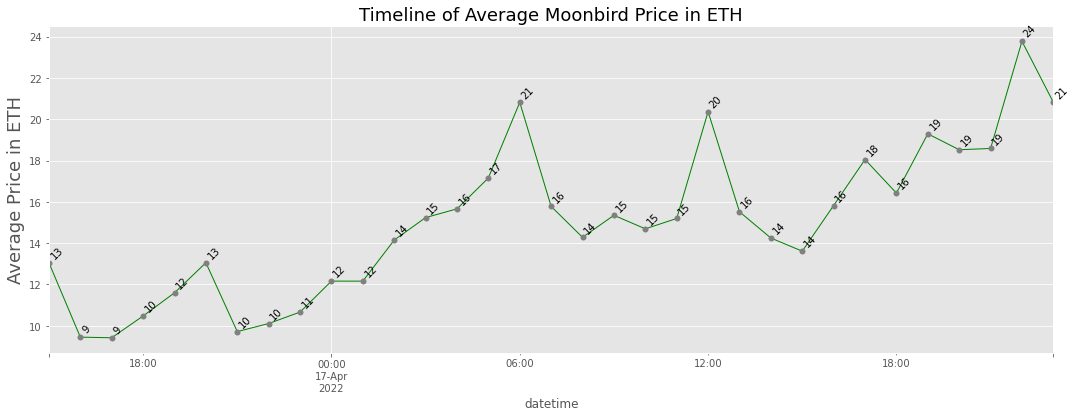

In [84]:
data = sales[sales['date'] < datetime(2022, 4, 18)]
data = data.resample('H', on='datetime').mean()['sale_price_eth']

ax = data.plot(figsize=(18,6), color="green", linewidth=1, marker='o', markerfacecolor='grey', markeredgewidth=0)

ax.set_alpha(0.8)
ax.set_title("Timeline of Average Moonbird Price in ETH", fontsize=18)
ax.set_ylabel("Average Price in ETH", fontsize=18)

dates = list(data.index)
values = list(data.values)

for i, j in zip(dates, values):
    ax.annotate(s="{:.0f}".format(j), xy=(i, j+.2), rotation=45)

## 2.2. Analyzing Moonbirds Traits and Rarity

Next, we analyze the relationship between Moonbirds' traits/rarity and their prices. 

The metadata DataFrame contains the attributes and rarity scores of all Moonbirds. We start by getting the list of attributes and check the distribution of the Moonbirds by specific attributes. 

In [63]:
metadata_cols = list(metadata.columns)
attributes = [col for col in metadata_cols if col.endswith('_attribute')]
print(attributes)

['Eyes_attribute', 'Headwear_attribute', 'Body_attribute', 'Feathers_attribute', 'Background_attribute', 'Beak_attribute', 'Outerwear_attribute', 'Eyewear_attribute']


In the example below, we're focusing on the feathers attribute, but we can do the same for all attributes. 

In [64]:
metadata['Feathers_attribute'].value_counts()

Red                    1842
Brown                  1437
Gray                   1225
Purple                 1122
Black                  1104
Blue                   1063
White                   885
Pink                    500
Green                   448
Metal                   150
Bone                    150
Legendary Bone           25
Legendary Crescent       14
Legendary Emperor         9
Legendary Professor       9
Legendary Sage            9
Legendary Guardian        4
Legendary Brave           4
Name: Feathers_attribute, dtype: int64

Next, we analyze the breakdown of Moonbirds sales by a specific attribute. To do do this, we will need to merge the sales DataFrame with the metadata DataFrame.

In [65]:
sales = sales.merge(metadata, how='left', on='asset_id')

In the example below, we're focusing on the feathers attribute, but we can do the same for all attributes.

In [66]:
feathers_attribute_sales = {}

feathers_attributes = list(metadata['Feathers_attribute'].unique())

for attribute in feathers_attributes:
    attribute_metadata = metadata[metadata['Feathers_attribute'] == attribute]
    attribute_sales = sales[sales['Feathers_attribute'] == attribute]
    n_moonbirds = len(attribute_metadata)
    n_sales = len(attribute_sales)
    max_sale = attribute_sales['sale_price_eth'].max()
    mean_sale = attribute_sales['sale_price_eth'].mean()
    
    feathers_attribute_sales[attribute] = {'#Moonbirds': n_moonbirds, '#Sales': n_sales, 
                                             'Highest Sale': format_number(max_sale, 'ETH'), 
                                           'Average Sale': format_number(mean_sale, 'ETH')}
    
pd.DataFrame.from_dict(feathers_attribute_sales, orient='index')

,#Moonbirds,#Sales,Highest Sale,Average Sale
Gray,1225,794,50.00 ETH,14.94 ETH
Red,1842,1320,50.00 ETH,14.92 ETH
Blue,1063,715,79.69 ETH,15.07 ETH
White,885,588,54.50 ETH,14.99 ETH
Purple,1122,790,73.75 ETH,15.00 ETH
Black,1104,836,75.00 ETH,15.63 ETH
Metal,150,93,80.00 ETH,27.14 ETH
Legendary Emperor,9,7,150.00 ETH,100.14 ETH
Brown,1437,1025,50.00 ETH,14.58 ETH
Pink,500,332,76.66 ETH,15.49 ETH


Next, we check the breakdown of Moonbirds sales by the number of attributes.

In [67]:
attribute_counts_sales = {}

attribute_counts = list(metadata['attribute_count'].unique())

for attribute in attribute_counts:
    attribute_metadata = metadata[metadata['attribute_count'] == attribute]
    attribute_sales = sales[sales['attribute_count'] == attribute]
    n_moonbirds = len(attribute_metadata)
    n_sales = len(attribute_sales)
    max_sale = attribute_sales['sale_price_eth'].max()
    mean_sale = attribute_sales['sale_price_eth'].mean()
    
    attribute_counts_sales[attribute] = {'#Moonbirds': n_moonbirds, '#Sales': n_sales, 
                                             'Highest Sale': format_number(max_sale, 'ETH'), 
                                           'Average Sale': format_number(mean_sale, 'ETH')}
    
pd.DataFrame.from_dict(attribute_counts_sales, orient='index')

,#Moonbirds,#Sales,Highest Sale,Average Sale
6,6610,4505,299.00 ETH,15.55 ETH
5,2057,1632,205.00 ETH,14.66 ETH
7,1263,796,130.00 ETH,18.28 ETH
8,46,36,80.00 ETH,35.54 ETH
3,24,19,350.00 ETH,114.34 ETH


Next, we analyze the relationship between sales prices and rarity scores. To do this, we plot sales prices vs. rarity scores.

### Plotting Sales Prices vs. Rarity Scores

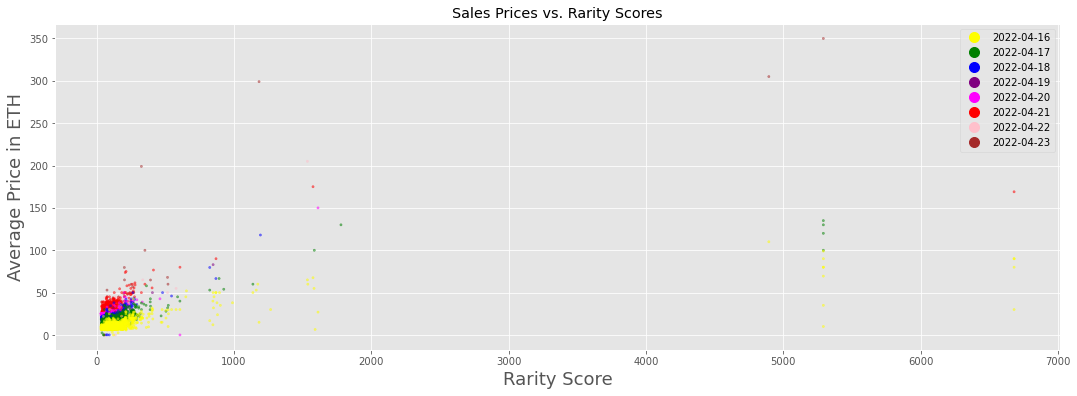

In [86]:
dates = list(sales['date'].unique())
labels = [str(date)[:10] for date in dates]
labels.sort()
colors = ['yellow','green','blue','purple','magenta','red', 'pink','brown']

plt.figure(figsize=(18,6))
plt.scatter(sales['overall_rarity_score'], sales['sale_price_eth'], 
            c=sales['date'], cmap=matplotlib.colors.ListedColormap(colors), alpha=0.5, s=5)

handles = []
for (i, label) in enumerate(labels):
    handle = mlines.Line2D([], [], color=colors[i], marker='o', linestyle='None',
                          markersize=10, label=label)
    handles.append(handle)
plt.legend(handles=handles)
plt.title('Sales Prices vs. Rarity Scores')
plt.xlabel("Rarity Score", fontsize=18)
plt.ylabel("Average Price in ETH", fontsize=18)
plt.show()

### Zooming into Moonbirds sales that have rarity scores smaller than 500

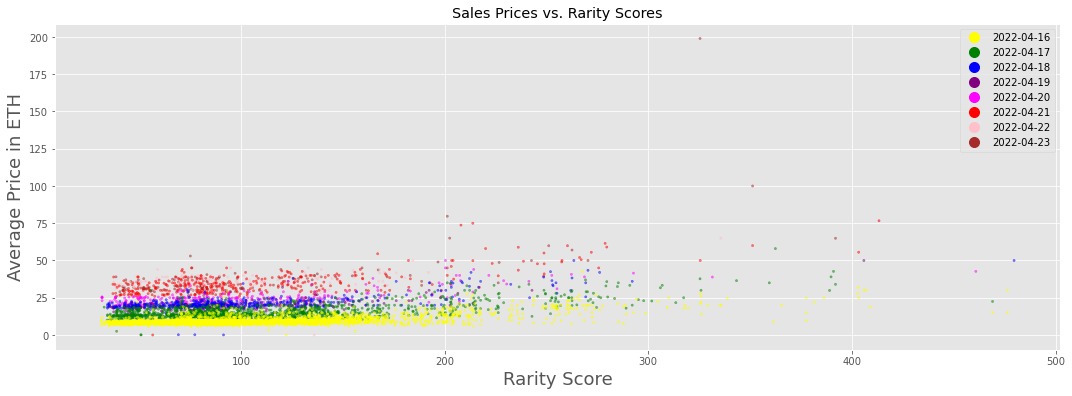

In [87]:
dates = list(sales['date'].unique())
labels = [str(date)[:10] for date in dates]
labels.sort()
colors = ['yellow','green','blue','purple','magenta','red', 'pink','brown']


data = sales[sales['overall_rarity_score'] < 500]
plt.figure(figsize=(18,6))
plt.scatter(data['overall_rarity_score'], data['sale_price_eth'], 
            c=data['date'], cmap=matplotlib.colors.ListedColormap(colors), alpha=0.5, s=5)

handles = []
for (i, label) in enumerate(labels):
    handle = mlines.Line2D([], [], color=colors[i], marker='o', linestyle='None',
                          markersize=10, label=label)
    handles.append(handle)
plt.legend(handles=handles)
plt.title('Sales Prices vs. Rarity Scores')
plt.xlabel("Rarity Score", fontsize=18)
plt.ylabel("Average Price in ETH", fontsize=18)
plt.show()

### Zooming into Moonbirds that have rarity scores higher than 500

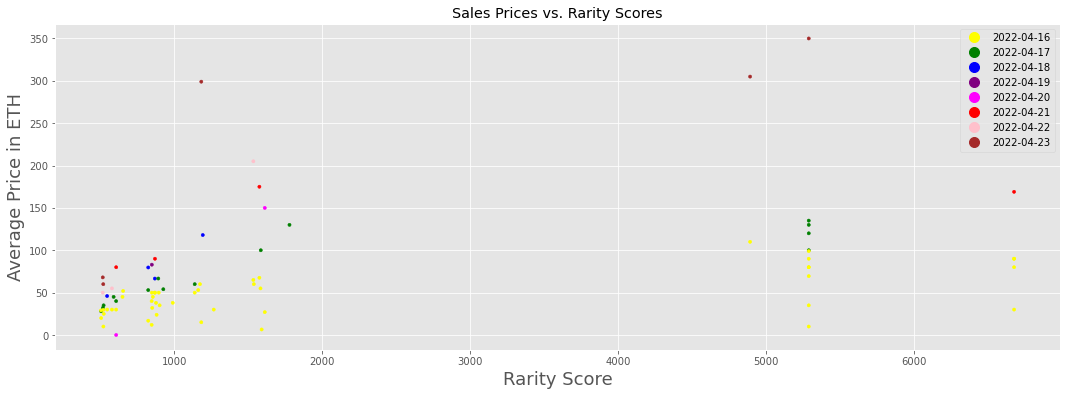

In [88]:
dates = list(sales['date'].unique())
labels = [str(date)[:10] for date in dates]
labels.sort()
colors = ['yellow','green','blue','purple','magenta','red', 'pink','brown']

data = sales[sales['overall_rarity_score'] >= 500]
plt.figure(figsize=(18,6))
plt.scatter(data['overall_rarity_score'], data['sale_price_eth'], 
            c=data['date'], cmap=matplotlib.colors.ListedColormap(colors), alpha=1, s=10)

handles = []
for (i, label) in enumerate(labels):
    handle = mlines.Line2D([], [], color=colors[i], marker='o', linestyle='None',
                          markersize=10, label=label)
    handles.append(handle)
plt.legend(handles=handles)
plt.title('Sales Prices vs. Rarity Scores')
plt.xlabel("Rarity Score", fontsize=18)
plt.ylabel("Average Price in ETH", fontsize=18)
plt.show()

We can see that the prices are increasing and the daily variance of prices of rare Moonbirds is decreasing.

## 2.3. Holders Analysis

Next, we analyze the  Moonbirds' holders. We start by checking the ratio of unique holders and we analyze the intersection between Moonbirds' owners and other major NFT projects.  

* Proof Collective
* Bored Ape Yacht Club (BAYC)
* Mutant Ape Yacht Club (MAYC)
* Bored Ape Kennel Club (BAKC)
* Meebits
* Doodles
* Cool Cats
* Azuki
* CLONE X
* World of Women

### Calculating ratio of unique holders

Text(0, 0.5, 'Unique Holders Ratio')

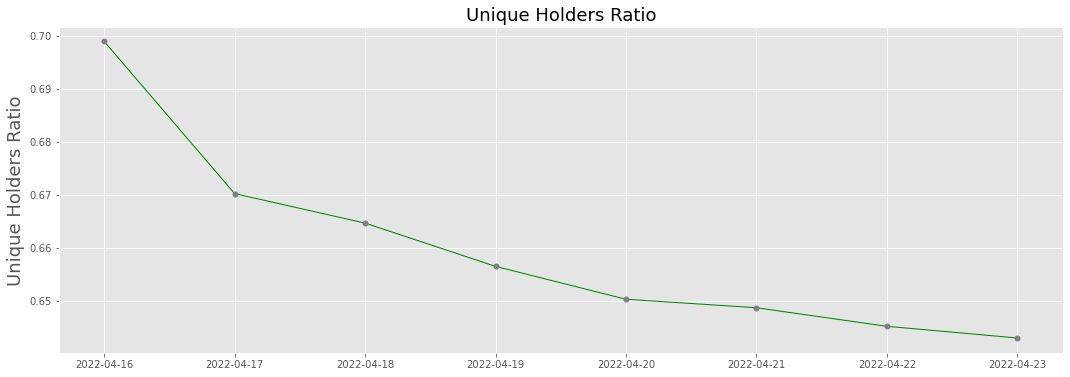

In [89]:
data_dict = {}

cols = list(owners_daily.columns)

for col in cols[1:]:
    n_assets = len(owners_daily[col].dropna())
    n_unique_holders = len(owners_daily[col].dropna().unique())
    data_dict[col] = float(n_unique_holders)/n_assets
    
data = pd.Series(index=data_dict.keys(), data=data_dict.values())

ax = data.plot(figsize=(18,6), color="green", linewidth=1, marker='o', markerfacecolor='grey', markeredgewidth=0)

ax.set_alpha(0.8)
ax.set_title("Unique Holders Ratio", fontsize=18)
ax.set_ylabel("Unique Holders Ratio", fontsize=18)

We can see that the ratio is dropping from 70% to below 65%.

### Top 10 Holders in the last day

In [74]:
owners_daily[cols[-1]].value_counts()[:10]

0x7b557aa52d0055d84b1e3f5487d9018f318372c1    109
0x83c8f28c26bf6aaca652df1dbbe0e1b56f8baba2     44
0x713a24fa5a811cdc1e9be72e670e8d3a6a9b89af     39
0xfd845e07717b0329d3f19fc920c97fba0bc4ee31     33
0x9ec8e8f64ec6bb47d944b4b830130b5fcf2da182     32
0x5afcabcbfeed16ea120a9d3c7c52d0212dda8111     31
0x6b52e83941eb10f9c613c395a834457559a80114     26
0x6615b87546e64851f33515d23d70c50c3a7929ea     23
0xabf9ba3867f15928ee4d29a85c3777a11f09f43d     22
0xdd72d3ae8368be34431871ef254d5e07ffebab8c     20
Name: 2022-04-23, dtype: int64

The first address in the list is owned by Moonbirds treasury. If you want to learn more about about a specific address, you can either look it up on [OpenSea](https://opensea.io/) or [Etherscan](https://etherscan.io/).

### Number of Addresses that hold 1 Moonbird

In [92]:
for col in cols:
    n_one_moonbirs_holders = (owners_daily[col].value_counts() == 1).sum()
    print("The number of addresses that hold 1 Moonbird on %s is: %s." %(col, n_one_moonbirs_holders) )

The number of addresses that hold 1 Moonbird on 2022-04-15 is: 1.
The number of addresses that hold 1 Moonbird on 2022-04-16 is: 5500.
The number of addresses that hold 1 Moonbird on 2022-04-17 is: 5132.
The number of addresses that hold 1 Moonbird on 2022-04-18 is: 5083.
The number of addresses that hold 1 Moonbird on 2022-04-19 is: 4996.
The number of addresses that hold 1 Moonbird on 2022-04-20 is: 4946.
The number of addresses that hold 1 Moonbird on 2022-04-21 is: 4908.
The number of addresses that hold 1 Moonbird on 2022-04-22 is: 4846.
The number of addresses that hold 1 Moonbird on 2022-04-23 is: 4838.


### Intersection between moonbirds' holders and other major NFT projects

We start by reading 2 CSV files that contain the holders of the following NFT projects on the date of minting (April 16th) and on the date of writing this blog post (April 23rd). 
* Proof Collective
* Bored Ape Yacht Club (BAYC)
* Mutant Ape Yacht Club (MAYC)
* Bored Ape Kennel Club (BAKC)
* Meebits
* Doodles
* Cool Cats
* Azuki
* CLONE X
* World of Women

In [93]:
owners_daily_20220416 = pd.read_csv('./data/owners_daily_20220416.csv')
owners_daily_20220423 = pd.read_csv('./data/owners_daily_20220423.csv')

In [117]:
minting_date_str = '2022-04-16'
writing_date_str = '2022-04-23'

intersection_dict = {}

for date_str in [minting_date_str, writing_date_str]:
    intersection_dict[date_str] = {}
    for col in owners_daily_20220416.columns:
        moonbirds_holders = list(owners_daily[date_str].dropna().unique())
        if date_str == minting_date_str:
            nft_holders = list(owners_daily_20220416[col].dropna().unique())
        else:
            nft_holders = list(owners_daily_20220423[col].dropna().unique())
        intersection_dict[date_str][col] = len(list(set(moonbirds_holders).intersection(nft_holders)))

In [119]:
pd.DataFrame(intersection_dict)

,2022-04-16,2022-04-23
Meebits,268,373
BAYC,293,520
MAYC,516,828
BAKC,251,391
Doodles,310,454
Cool Cats,370,419
Azuki,363,535
CLONE X,392,557
World of Women,194,266
Proof Collective,844,848


We can see that the the holders of the NFT projects above added more Moonbirds to their wallets.

# Conclusion

In this blog post, we did a deep dive analysis of the first trading week of Moonbirds. We analyzed the sales volume and price movements, we analyzed how the traits and rarity affect the price, and we analyzed the intersection between Moonbirds' owners and other major NFT projects. The analysis introduced here can be extended to other scenarios or other NFT collections.